# Import libraries

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Read the Data Set

In [ ]:
df = pd.read_csv('GOOG.csv')

In [ ]:
# Rename columns
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume']

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401


# Data Preprocessing + Visualization

In [ ]:
# Since 'Close' contains the same values as 'AdjClose', we drop the AdjClose column
df["Tomorrow"] = df["Close"].shift(-1)
df.drop(['AdjClose'], axis=1, inplace=True)
df.dropna(inplace=True)
df.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Tomorrow    0
dtype: int64

### Scaling features

In [ ]:
scaler = MinMaxScaler()
cols = ['Open', 'High', 'Low',	'Close', 'Volume']
X, y = df[cols], df['Tomorrow']
X_scaled = scaler.fit_transform(X)
df[cols] = X_scaled

# Training the model

In [ ]:

X = df[['Open', 'Close', 'High', 'Low', 'Volume']]
y = df[['Tomorrow']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=156)
split_ratio = 0.9
split_index = int(len(df) * split_ratio)
df_train, df_test = df[:split_index], df[split_index:]
X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]

test = y_test[['Tomorrow']].values
df_test = pd.DataFrame(test, columns=['Actual'])
df_test['Date'] = y_test.index
df_test.set_index('Date', inplace=True)

df_test.head()

,Actual
Date,
2022-02-25,134.891006
2022-02-28,134.167999
2022-03-01,134.751495
2022-03-02,134.307999
2022-03-03,132.121994


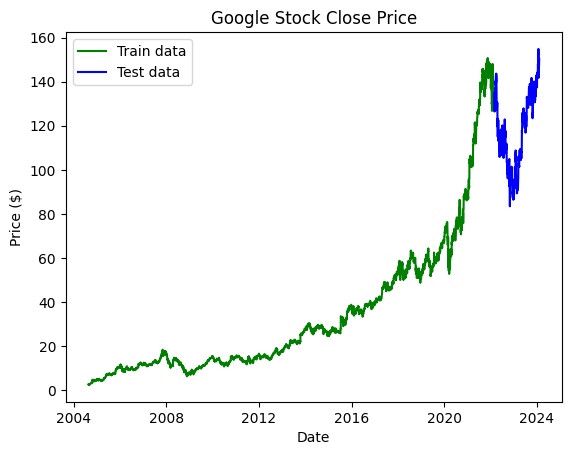

In [ ]:
# Plot train and test data
plt.plot(y_train['Tomorrow'], 'green', label='Train data')
plt.plot(y_test['Tomorrow'], 'blue', label='Test data')
plt.title('Google Stock Close Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()

## Optimizing Parameters using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {
    'n_estimators': [100, 200, 300, 400, 500, 1000, 2000],
    'max_features': [None, 'sqrt','log2'],
    'max_depth': [None,2,3,4,5,6],
    'bootstrap': [True, False],
    'random_state' : [156]
}

## Grid Search function
grid_randomforest = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
model = grid_randomforest.fit(X_train, np.ravel(y_train))

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_randomforest.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_randomforest.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_randomforest.best_params_)

In [ ]:
model = RandomForestRegressor(max_features='sqrt', n_estimators=400, random_state=156)

model = model.fit(X_train, np.ravel(y_train))

predicted_values = model.predict(X_test)
df_test['Predicted'] = predicted_values

df_test.head()

In [ ]:
mse = mean_squared_error(df_test['Actual'], df_test['Predicted'])
mae = mean_absolute_error(df_test['Actual'], df_test['Predicted'])
rmse = math.sqrt(mean_squared_error(df_test['Actual'], df_test['Predicted']))
print('MSE:\t', str(mse))
print('MAE:\t', str(mae))
print('RMSE:\t', str(rmse))

In [ ]:
# Plot predicted vs true stock price
plt.title('Google Stock Close Price - True vs Predicted')
# plt.plot(df_train.index, df_train['Close'], color='green', label = 'Train data')
plt.plot(df_test.index, df_test['Predicted'], color = 'green', label = 'Predicted')
plt.plot(df_test.index, df_test['Actual'], color = 'blue', label = 'True')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# Plot results for 2024 only
df_eval_2024_onwards = df_test[df_test.index.year >= 2024]
plt.title('Google Stock Close Price - True vs Predicted for 2024')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.plot(df_eval_2024_onwards['Predicted'], 'green', label='Predicted')
plt.plot(df_eval_2024_onwards['Actual'], 'blue', label='True')
plt.xticks(rotation=20)
plt.legend(loc='upper left')
plt.show()